In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

#### Load the data

In [3]:
data = pd.read_csv('AirPassengers.csv', parse_dates = ['Month'], index_col = 'Month')
data.head(5)

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


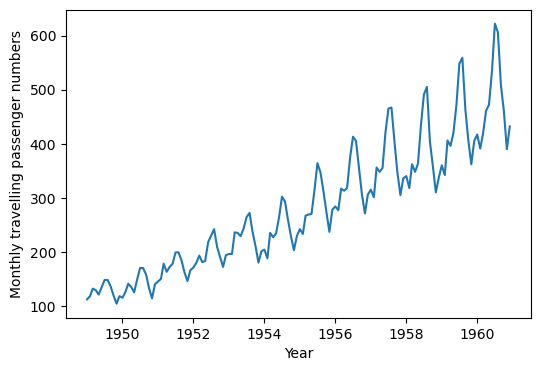

In [4]:
plt.figure(figsize = (6,4))
plt.plot(data)
plt.xlabel('Year')
plt.ylabel('Monthly travelling passenger numbers')
plt.show()

In [5]:
!pip install statsmodels==0.13.5

In [6]:
import statsmodels.api as sm

In [8]:
from statsmodels.tsa.stattools import acf, pacf, adfuller

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

#### Check for stationarity

In [10]:
def check_stationarity(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print(f'ADF Test Statistic Value:{result[0]}')
    print(f'P Value: {result[1]}')
    print(f'ADF Critical values:{result[4]}')

print('ADF Test Results')
check_stationarity(data['#Passengers'])

ADF Test Results
ADF Test Statistic Value:0.8153688792060441
P Value: 0.9918802434376409
ADF Critical values:{'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}


#### Applying Log Transformation

In [11]:
log_data = np.log(data)

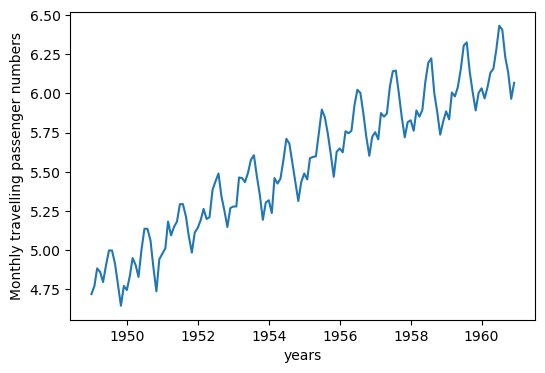

In [12]:
plt.figure(figsize = (6,4))
plt.plot(log_data, label = 'log transform')
plt.xlabel('years')
plt.ylabel('Monthly travelling passenger numbers')
plt.show()

#### Decomposition

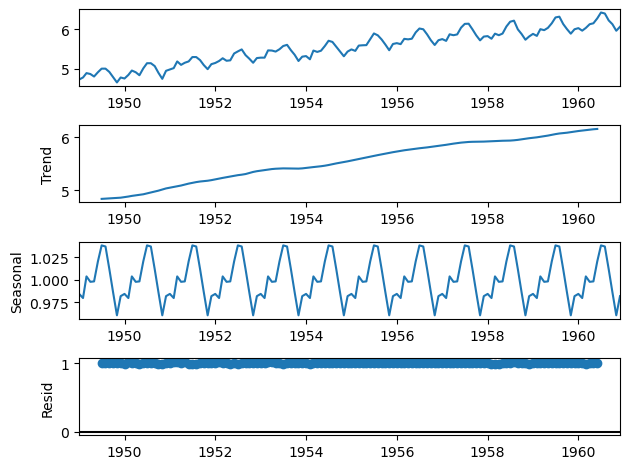

In [13]:
decomposition = seasonal_decompose(log_data, model = 'multiplicative')
fig = decomposition.plot()
plt.tight_layout()

#### Differencing

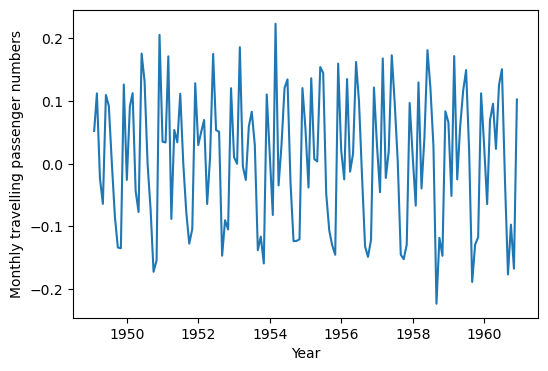

ADF Test Statistic Value:-2.7171305983881333
P Value: 0.07112054815085872
ADF Critical values:{'1%': -3.4825006939887997, '5%': -2.884397984161377, '10%': -2.578960197753906}


In [14]:
diff_data = log_data.diff().dropna() # dropna because rolling mean will not be possible for all data points 
plt.figure(figsize = (6,4))
plt.plot(diff_data)
plt.xlabel('Year')
plt.ylabel('Monthly travelling passenger numbers')
plt.show()

check_stationarity(diff_data['#Passengers'])

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#### Plotting ACF and PACF plots

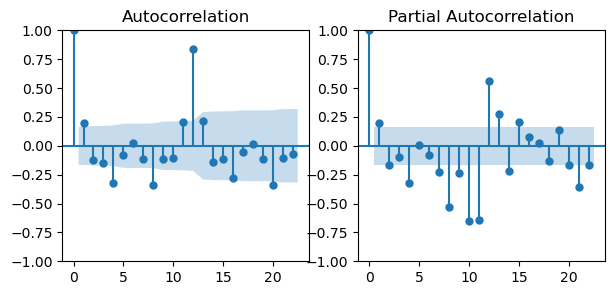

In [16]:
# ACF understands the relationship between the current value and the lag that you need to follow till end.
fig,(ax1,ax2) = plt.subplots(1,2, figsize = (7,3))
plot_acf(diff_data, ax=ax1);
plot_pacf(diff_data, ax=ax2);


#### Going for train-test split

In [17]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [18]:
train = log_data[:132]
test = log_data[132:]

#### Running ARIMA model as baseline model

In [19]:
arima_model = ARIMA(train, order = (2,1,1))
arima_result = arima_model.fit()
print(arima_result.summary())

# Forecasting
arima_forecast = arima_result.forecast(steps = len(test))
arima_forecast = np.exp(arima_forecast) # earlier forecast was done on log data but we want on normal data so using 'exp' 
# to change it. Also differincing data was not taken since the differencing function was used to make the data stationary.
# We do not want the stationary data to make predictions. so 'exp' function changes log data back to normal data.
# ARIMA was used as a base line model so it didn't include the 'seasonal variation'. This is checked by 'SARIMAX'.
# Since ARIMAX is used as baseline model, it predicts the worst our algo can perform and to further optimize it, we use 'SARIMAX'.

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  132
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 118.451
Date:                Thu, 09 Jan 2025   AIC                           -228.902
Time:                        15:50:31   BIC                           -217.401
Sample:                    01-01-1949   HQIC                          -224.229
                         - 12-01-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9640      0.107      9.006      0.000       0.754       1.174
ar.L2         -0.3642      0.123     -2.968      0.003      -0.605      -0.124
ma.L1         -0.8268      0.111     -7.451      0.0

#### Running SARIMAX model as optimized version of ARIMA

In [20]:
sarimax_model = SARIMAX(train, order = (2,1,1), seasonal_order = (2,1,1,12)) # (Seasonal order since we checked for 'E' and 'T'
sarimax_result = sarimax_model.fit()                            # under ETS but did not include 'seasonality' component.
print(sarimax_result.summary())                                 # Also since we have our data of a year as monthly records
                                                                # we have used 12 in 'seasonal order' component)
# Forecasting
sarimax_forecast = sarimax_result.forecast(steps = len(test))
sarimax_forecast = np.exp(sarimax_forecast)

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                        #Passengers   No. Observations:                  132
Model:             SARIMAX(2, 1, 1)x(2, 1, 1, 12)   Log Likelihood                 224.196
Date:                            Thu, 09 Jan 2025   AIC                           -434.392
Time:                                    15:50:43   BIC                           -414.938
Sample:                                01-01-1949   HQIC                          -426.492
                                     - 12-01-1959                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3102      0.429      0.723      0.470      -0.531       1.151
ar.L2          0.0733      0.185   

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


#### Plotting all the graphs

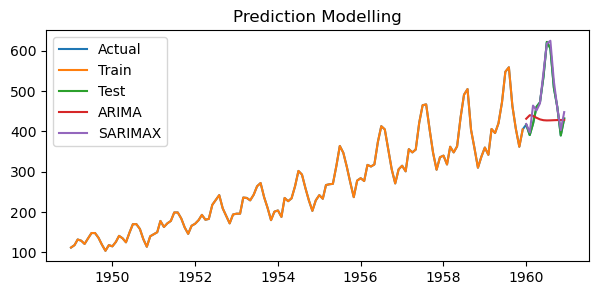

In [21]:
plt.figure(figsize = (7,3))
plt.plot(data, label = 'Actual')
plt.plot(np.exp(train), label = 'Train')
plt.plot(np.exp(test), label = 'Test')
plt.plot(arima_forecast, label = 'ARIMA')
plt.plot(sarimax_forecast, label = 'SARIMAX')
plt.legend()
plt.title('Prediction Modelling')
plt.show()

In [22]:
# data = pd. read_csv('AirPassengers.csv', parse_dates=['Month'], index_col='Month')
# log_data = np. log(data['#Passengers'])

# def optimize_ARIMA(data, pdq_range):
# best_aic = float('inf')
# best_order = None
# for order in pdq_range:
# try:
# model = ARIMA(data, order=order)
# results = model. fit()
# if results.aic < best_aic:
# best_aic, best_order = results.aic, order

# continue
# return best_order

# def optimize_SARIMAX(data, pdq_range, seasonal_pdq_range):
# best_aic = float('inf')
# best_order, best_seasonal_order = None, None
# for order in pdq_range:
# for seasonal_order in seasonal_pdq_range: #do check this
# try:
# model = SARIMAX(data, order=order, seasonal_order=seasonal_order)
# results = model. fit()
# if results.aic < best_aic:
# best_aic, best_order, best_seasonal_order = results.aic, order, seasonal_order

# continue #that val needs to be skipped as in do not take it
# return best_order, best_seasonal_order

# # pdq, you have taken here - check
# p = d = q = range(0, 3)
# pdq = list(itertools.product(p, d, q))
# seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
# # arima order code - optimize later
# best_arima = optimize_ARIMA(log_data, pdq)
# print(f'ARIMA Order: {best_arima}')